In [1]:
from SimPEG import * 
%matplotlib inline
import matplotlib.pyplot as plt

# DC Resistivity Simulations

DC resistivity is a zero-frequency electromagnetic problem. A DC resistivity geophysical survey is sensitive to variations in electrical conductivity. 

The governing equation is: 

$$
\nabla \cdot \sigma \nabla \phi = -s
$$

where $\sigma$ is the electrical conductivity (S/m), $\phi$ is the electrical potential (V), and $s$ is the source.  

## Set up a Mesh

We will solve the DC problem using a finite volume simulation, which requires that we set up a mesh on which to compute. 

In [2]:
# Define a unit square domain 
# This can be hidden depending on how much you want to show
nx,ny = 60,60 # number of cells in x,y
mesh = Mesh.TensorMesh([nx,ny]) # build a tensor mesh
sigma = np.ones(mesh.nC) # assign a conductivity model

# create source
xp, yp = 0.25, 0.5
xn, yn = 0.75, 0.5
s = np.zeros(mesh.nC)
indp = Utils.closestPoints(mesh,np.r_[xp,yp],'CC')
indn = Utils.closestPoints(mesh,np.r_[xn,yn],'CC')
s[indp] = 1.
s[indn] = -1

# conductive block
sigmabl = 100.
p0 = np.r_[0.4,0.4]
p1 = np.r_[0.6,0.6]

In [3]:
# Build differential operators
# This can be hidden and imported depending on how much you want to expose
def getOperators(mesh,sigma):
    Div = mesh.faceDiv
    Sigma = Utils.sdiag(1/(mesh.aveF2CC.T * (1/sigma)))
    Grad = mesh.cellGrad
    return Div, Sigma, Grad

def getA(mesh,sigma): 
    Div, Sigma, Grad = getOperators(mesh,sigma)
    return Div * Sigma * Grad

def getAinv(mesh,sigma):
    return Solver(getA(mesh,sigma))

## DC Resistivity
### $ \nabla \cdot \sigma \nabla \phi = -s $

In [9]:
# Construct A Matrix
Div, Sigma, Grad = getOperators(mesh,sigma)
A = Div * Sigma * Grad # looks like the equation!
Ainv = Solver(A)

In [10]:
phi = Ainv * -s

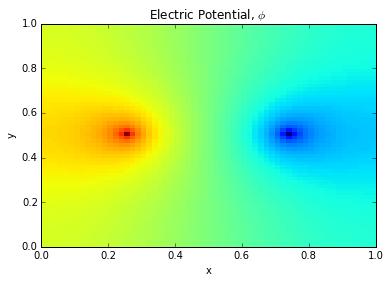

In [11]:
mesh.plotImage(phi)
plt.title('Electric Potential, $\phi$')

# Lets Explore

### Move the source

In [7]:
# this can be hidden and imported 
def SolveDCprimary(xp,yp,xn,yn,mesh,sigma):
    s = np.zeros(mesh.nC)
    indp = Utils.closestPoints(mesh,np.r_[xp,yp],'CC')
    indn = Utils.closestPoints(mesh,np.r_[xn,yn],'CC')
    s[indp] = 1.
    s[indn] = -1.
    
    Ainv = getAinv(mesh,sigma)
    phi = Ainv * -s

    return phi 

def plotPhi(phi):
    mesh.plotImage(phi)
    plt.title('Electric Potential, $\phi$')
    plt.show()

The model has a uniform background conductivity:

- `sigma` = 1 S/m

We excite the system using a source which has positive and negative electrodes (ie. a current source and a current). We will plot the electric potential; when a DC resistivity survey is conducted, the data are potential differences, measured in units of volts. 

The parameters you can explore here are:

- `xp`: x-position of the positive electrode
- `yp`: y-position of the positive electrode
- `xn`: x-position of the negative electrode
- `yn`: y-position of the negative electrode 

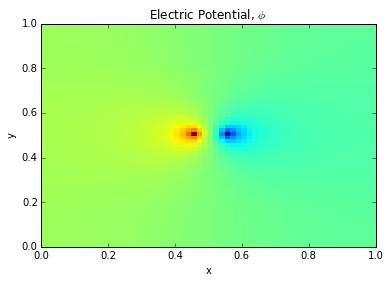

<function __main__.<lambda>>

In [10]:
from IPython.html.widgets import interact

interact(lambda xp,yp,xn,yn: plotPhi(SolveDCprimary(xp,yp,xn,yn,mesh,sigma)), xp=[0.1,0.8,0.05],yp=[0.1,0.9,0.05],xn=[0.2,0.9,0.05],yn=[0.1,0.9,0.05])

## Add a conductive block: 
Can you find it?

In [11]:
def CondBlock(xp,yp,xn,yn,mesh,sigma,sigmabl,p0,p1):  
    sigmaBl = Utils.ModelBuilder.addBlock(mesh.gridCC, sigma, p0, p1, sigmabl)
    return SolveDCprimary(xp,yp,xn,yn,mesh,sigmaBl)

What happens if we add a conductive block?

A conductive block with a conductivity of 100 S/m in the 1 S/m background. If you move the positive and negative electrodes around, can you find it? How big is it?

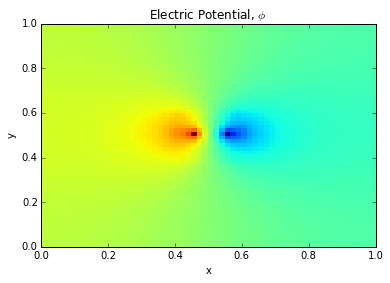

<function __main__.<lambda>>

In [12]:
interact(lambda xp,yp,xn,yn: plotPhi(CondBlock(xp,yp,xn,yn,mesh,sigma,sigmabl,p0,p1)), xp=[0.1,0.8,0.05],yp=[0.1,0.9,0.05],xn=[0.2,0.9,0.05],yn=[0.1,0.9,0.05])

## Plot the secondary potential 

In [13]:
def CondBlockSecondary(xp,yp,xn,yn,mesh,sigma,sigmabl,p0,p1):
    sigmaBl = Utils.ModelBuilder.addBlock(mesh.gridCC, sigma, p0, p1, sigmabl)
    sec = SolveDCprimary(xp,yp,xn,yn,mesh,sigmaBl) - SolveDCprimary(xp,yp,xn,yn,mesh,sigma)
    return sec

Here, we plot the difference in potentials computed with and without the block, ie. the signal due to the presence of the block

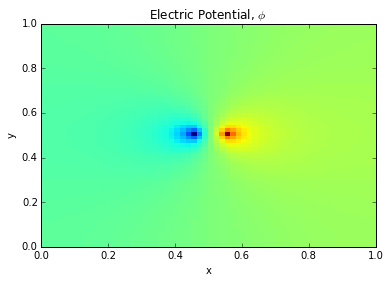

<function __main__.<lambda>>

In [14]:
interact(lambda xp,yp,xn,yn: plotPhi(CondBlockSecondary(xp,yp,xn,yn,mesh,sigma,sigmabl,p0,p1)), xp=[0.1,0.8,0.05],yp=[0.1,0.9,0.05],xn=[0.2,0.9,0.05],yn=[0.1,0.9,0.05])

## Your Turn

Here, you can play with all of the parameters in this model:

- `xp`: x-position of the positive electrode
- `yp`: y-position of the positive electrode
- `xn`: x-position of the negative electrode
- `yn`: y-position of the negative electrode
- `log10_sigmabl`: $log_{10}(\sigma_{\text{block}})$
- `blcx` : x-center of the block
- `blcy` : y-center of the block
- `bldx` : x-width of the block
- `bldy` : y-width of the block

The first widget shows the measured potential and the second shows the secondary potential

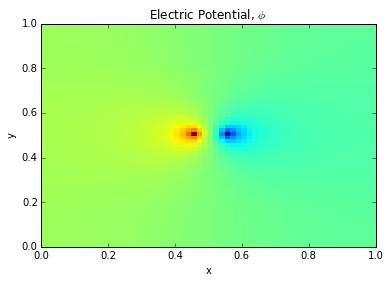

<function __main__.<lambda>>

In [15]:
# total potential
interact(lambda xp,yp,xn,yn,log10_sigmabl,blcx,blcy,bldx,bldy: plotPhi(CondBlock(xp,yp,xn,yn,mesh,sigma,10.**(log10_sigmabl),np.r_[blcx-bldx/2.,blcy-bldy/2.],np.r_[blcx+bldx/2.,blcy+bldy/2.])), xp=[0.1,0.8,0.05],yp=[0.1,0.9,0.05],xn=[0.2,0.9,0.05],yn=[0.1,0.9,0.05],log10_sigmabl=[-5,5,0.5],blcx=[0.,1.,0.05],blcy=[0.,1.,0.05],bldx=[0.,1.,0.05],bldy=[0.,1.,0.05])

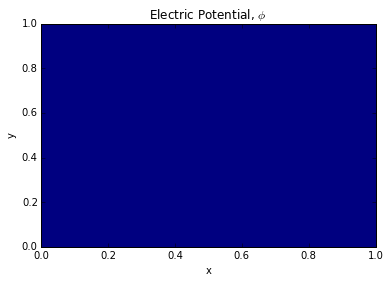

<function __main__.<lambda>>

In [16]:
# secondary potential
interact(lambda xp,yp,xn,yn,log10_sigmabl,blcx,blcy,bldx,bldy: plotPhi(CondBlockSecondary(xp,yp,xn,yn,mesh,sigma,10.**(log10_sigmabl),np.r_[blcx-bldx/2.,blcy-bldy/2.],np.r_[blcx+bldx/2.,blcy+bldy/2.])), xp=[0.1,0.8,0.05],yp=[0.1,0.9,0.05],xn=[0.2,0.9,0.05],yn=[0.1,0.9,0.05],log10_sigmabl=[-5,5,0.5],blcx=[0.,1.,0.05],blcy=[0.,1.,0.05],bldx=[0.,1.,0.05],bldy=[0.,1.,0.05])